In [1]:
import numpy as np
import pandas as pd
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar
from feature_engine.datetime import DatetimeFeatures
import matplotlib.pyplot as plt
from cloudpickle import dump, load

from sklearn.preprocessing import (
    FunctionTransformer,
    OrdinalEncoder,
    OneHotEncoder,
    StandardScaler,
)

from darts import TimeSeries
from darts.models import (
    LightGBMModel,
    XGBModel,
    VARIMA,
    RNNModel,
)

from darts.metrics import smape, mape, mae, mse
from darts.dataprocessing.transformers import Scaler, InvertibleMapper
import optuna

import warnings
warnings.filterwarnings("ignore")

In [2]:
# define helper function to add time-related features

def add_time_features(ride_counts, time_col):
    """add a bunch of useful time-related features"""

    season_month = {12:'Winter', 1:'Winter', 2:'Winter',
                    3:'Spring', 4:'Spring', 5:'Spring',
                    6:'Summer', 7:'Summer', 8:'Summer',
                    9:'Autumn', 10:'Autumn', 11:'Autumn'}

    ride_counts['date'] = ride_counts.loc[:, time_col].dt.date

    dtfs = DatetimeFeatures(
                variables=time_col,
                features_to_extract=["year", "quarter", "month",
                                     "hour", "day_of_week", "weekend"],
                drop_original=False,
    )
    ride_counts = dtfs.fit_transform(ride_counts)
    ride_counts.columns = ride_counts.columns.str.removeprefix('time_')
    ride_counts.loc[:, 'season'] = ride_counts['month'].map(season_month)

    holidays = calendar().holidays(start=ride_counts[time_col].min(), end=ride_counts[time_col].max())
    ride_counts['is_holiday'] = pd.to_datetime(ride_counts.loc[:, 'date']).isin(holidays)
    ride_counts['is_workday'] = ~(ride_counts['weekend'] | ride_counts['is_holiday'])

    return ride_counts

### Get data sources

In [3]:
weather_data = pd.read_csv("data/DCweather_clean.csv",
                      parse_dates=['datetime'],
                      index_col='datetime')

In [4]:
train_data = pd.read_csv("data/train_data.csv", parse_dates=['time'])
test_data = pd.read_csv("data/test_data.csv", parse_dates=['time'])

In [5]:
all_data = pd.concat([train_data, test_data])

In [6]:
# define training, validation (and test splits)
# dataset starts 2021-03-01, ends 2023-06-30
# keep June 2023 as final test set, Mar - May 2023 as validation set
end_train = '2023-02-28 23:59:00'
end_val = '2023-05-31 23:59:00'
SAMPLES_PER_DAY = 24

To reduce the number of samples, while still keeping an operationally sensible level of granularity, downsample the bike counts to every 2 hours.
Then add the time-relevant features using the add_time_features function defined above, and join the weather data to the array.

In [7]:
rule = "2H"
SAMPLES_PER_DAY = 12
train_data = train_data.resample(rule, on='time').sum().reset_index()
test_data = test_data.resample(rule, on='time').sum().reset_index()
all_data = all_data.resample(rule, on='time').sum().reset_index()
weather_data = weather_data.asfreq(rule)

In [8]:
train_data = add_time_features(train_data, 'time').set_index('time')
test_data = add_time_features(test_data, 'time').set_index('time')
all_data = add_time_features(all_data, 'time').set_index('time')

In [9]:
train_data = train_data.join(weather_data).asfreq(rule).ffill()
test_data = test_data.join(weather_data).asfreq(rule).ffill()
all_data = all_data.join(weather_data).asfreq(rule).ffill()

Now define exogenous variables and data columns, for model

In [10]:
clus_columns = train_data.columns[train_data.columns.str.contains("clus")]

exog_cols = ['year', 'month', 'season', 'hour', 'is_workday', 'is_holiday', 'rush_hour']
#exog_cols = ['year', 'month', 'hour', 'is_workday', 'is_holiday']

def define_exog(data, data_cols, exog_cols):
    exog = data.drop(data_cols, axis=1)
    exog.drop(["date", "quarter", "feelslike", "visibility"], axis=1, inplace=True)
    exog[['year', 'day_of_week', 'weekend']] = exog[['year', 'day_of_week', 'weekend']].astype("category")
    exog['rush_hour'] = ((exog['hour'] > 5) & (exog['hour'] <= 9)) | ((exog['hour'] >= 16) & (exog['hour'] < 20))
    exog['condition'].replace({'rainy':0, 'cloudy':1, 'clear':2}, inplace=True)
    exog['season'].replace({'Winter':0, 'Autumn':1, 'Spring':1, 'Summer':2}, inplace=True)
    exog = exog.loc[:, exog_cols]
    return exog

exog_train = define_exog(train_data, clus_columns, exog_cols)
exog_test = define_exog(test_data, clus_columns, exog_cols)
exog_all = define_exog(all_data, clus_columns, exog_cols)

train_data = train_data.loc[:, clus_columns]
test_data = test_data.loc[:, clus_columns]
all_data = all_data.loc[:, clus_columns]

In [11]:
train_data.head(5)

,clus0,clus1,clus2,clus3,clus4,clus5,clus6,clus7,clus8,clus9,...,clus20,clus21,clus22,clus23,clus24,clus25,clus26,clus27,clus28,clus29
time,,,,,,,,,,,,,,,,,,,,,
2021-03-01 00:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2021-03-01 02:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2021-03-01 04:00:00,0.0,1.0,4.0,0.0,0.0,0.0,1.0,0.0,0.0,3.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2021-03-01 06:00:00,0.0,4.0,2.0,3.0,5.0,1.0,10.0,1.0,1.0,4.0,...,5.0,9.0,5.0,0.0,6.0,4.0,0.0,5.0,0.0,1.0
2021-03-01 08:00:00,0.0,10.0,4.0,1.0,4.0,2.0,7.0,5.0,1.0,6.0,...,10.0,8.0,1.0,6.0,3.0,4.0,0.0,8.0,0.0,1.0


### Multivariate forecasting using DARTS

Now I make use of a helpful python library called [DARTS](https://unit8co.github.io/darts/index.html). To make hyperparameter optimization less laborious than a naive grid-search, I also use the Bayesian optimization library [optuna](https://optuna.org/).

The first step is to train the model using the training set (with validation set for hyperparameter optimization). We can evaluate the model by backtesting on the held-out test set, and also use `predict` to make future forecasts.

In [12]:
train_ts = TimeSeries.from_dataframe(train_data.loc[:end_train, :])
val_ts = TimeSeries.from_series(train_data.loc[end_train:end_val, :])
test_ts = TimeSeries.from_series(test_data)

exog_all_ts = TimeSeries.from_dataframe(exog_all)
exog_train_ts = TimeSeries.from_dataframe(exog_train.loc[:end_train, :])
exog_val_ts = TimeSeries.from_dataframe(exog_train.loc[end_train:end_val, :])
exog_test_ts = TimeSeries.from_dataframe(exog_test)

encoders = {
    'cyclic': {'future': ['month', 'hour']},
    'datetime_attribute': {'future': ['year']},
}

In [13]:
# unused for now, in case we want to log transform the counts

logmapper = InvertibleMapper(
    fn=lambda x: np.log(x+1),
    inverse_fn=lambda x: np.exp(x)-1,
)

In [15]:
# optuna objective function
# we set suggestions and ranges for hyperparameters, define our loss function
# and optuna will use Bayesian methods to optimize the hyperparameters.

def objective(trial):

    days_out = 14
    out_len = days_out * SAMPLES_PER_DAY

    hyper_params = \
        {"n_estimators": trial.suggest_int("n_estimators", 10, 100),
         "max_depth": trial.suggest_int("max_depth", 5, 25),
         "learning_rate": trial.suggest_float("learning_rate", 1e-3, 1e-1, log=True),
         }

    # build and fit gradient-boosting model
    model = LightGBMModel(
        lags=1,
        output_chunk_length=out_len,
        add_encoders=encoders,
        lags_future_covariates=[0],
        **hyper_params,
    )

    model.fit(
        train_ts,
        future_covariates=exog_train_ts,
        max_samples_per_ts=SAMPLES_PER_DAY*100,
    )

    # Evaluate how good it is on the validation set
    preds = model.predict(
        n=len(val_ts),
        future_covariates=exog_val_ts,
    )

    errors = smape(val_ts, preds, n_jobs=-1, verbose=True)
    #errors = mae(val_ts, preds)
    error_val = np.mean(errors)

    return error_val if error_val != np.nan else float("inf")

# callback for printing during optimization
def print_callback(study, trial):
    print(f"Current value: {trial.value}, Current params: {trial.params}")
    print(f"Duration: {trial.duration}")
    print(f"Best value: {study.best_value}, Best params: {study.best_trial.params}")

# run the "study", with diagnostic printing
study = optuna.create_study(direction="minimize")
#study.optimize(objective, timeout=60*120, callbacks=[print_callback])
study.optimize(objective, timeout=60*120)

[I 2023-09-09 14:12:20,996] A new study created in memory with name: no-name-a6d99a71-1fe9-4496-9c41-4fc01d0664ee


  0%|          | 0/1 [00:00<?, ?it/s]

[I 2023-09-09 14:14:47,675] Trial 0 finished with value: 82.53192831746948 and parameters: {'n_estimators': 31, 'max_depth': 25, 'learning_rate': 0.03607180519533356}. Best is trial 0 with value: 82.53192831746948.


  0%|          | 0/1 [00:00<?, ?it/s]

[I 2023-09-09 14:16:38,305] Trial 1 finished with value: 96.82658349949243 and parameters: {'n_estimators': 20, 'max_depth': 9, 'learning_rate': 0.006660881560582998}. Best is trial 0 with value: 82.53192831746948.


  0%|          | 0/1 [00:00<?, ?it/s]

[I 2023-09-09 14:22:04,670] Trial 2 finished with value: 97.24014731022403 and parameters: {'n_estimators': 92, 'max_depth': 6, 'learning_rate': 0.001283851384405764}. Best is trial 0 with value: 82.53192831746948.


  0%|          | 0/1 [00:00<?, ?it/s]

[I 2023-09-09 14:24:55,115] Trial 3 finished with value: 78.97920257656024 and parameters: {'n_estimators': 51, 'max_depth': 6, 'learning_rate': 0.09498813258066105}. Best is trial 3 with value: 78.97920257656024.


  0%|          | 0/1 [00:00<?, ?it/s]

[I 2023-09-09 14:29:50,872] Trial 4 finished with value: 97.95682522991832 and parameters: {'n_estimators': 78, 'max_depth': 20, 'learning_rate': 0.0011419531639994382}. Best is trial 3 with value: 78.97920257656024.


  0%|          | 0/1 [00:00<?, ?it/s]

[I 2023-09-09 14:35:50,545] Trial 5 finished with value: 79.37550552668553 and parameters: {'n_estimators': 93, 'max_depth': 21, 'learning_rate': 0.048007127897837384}. Best is trial 3 with value: 78.97920257656024.


  0%|          | 0/1 [00:00<?, ?it/s]

[I 2023-09-09 14:41:35,370] Trial 6 finished with value: 84.57106730323049 and parameters: {'n_estimators': 90, 'max_depth': 20, 'learning_rate': 0.010205164851240458}. Best is trial 3 with value: 78.97920257656024.


  0%|          | 0/1 [00:00<?, ?it/s]

[I 2023-09-09 14:42:47,476] Trial 7 finished with value: 84.33305791646217 and parameters: {'n_estimators': 10, 'max_depth': 18, 'learning_rate': 0.0905973943822434}. Best is trial 3 with value: 78.97920257656024.


  0%|          | 0/1 [00:00<?, ?it/s]

[I 2023-09-09 14:47:18,493] Trial 8 finished with value: 98.04745018214913 and parameters: {'n_estimators': 68, 'max_depth': 14, 'learning_rate': 0.0012588294902012508}. Best is trial 3 with value: 78.97920257656024.


  0%|          | 0/1 [00:00<?, ?it/s]

[I 2023-09-09 14:49:23,279] Trial 9 finished with value: 97.90062578425164 and parameters: {'n_estimators': 25, 'max_depth': 13, 'learning_rate': 0.0036452357838027364}. Best is trial 3 with value: 78.97920257656024.


  0%|          | 0/1 [00:00<?, ?it/s]

[I 2023-09-09 14:52:01,590] Trial 10 finished with value: 82.75328606941213 and parameters: {'n_estimators': 48, 'max_depth': 5, 'learning_rate': 0.023697481159319075}. Best is trial 3 with value: 78.97920257656024.


  0%|          | 0/1 [00:00<?, ?it/s]

[I 2023-09-09 14:55:41,742] Trial 11 finished with value: 79.94035507989095 and parameters: {'n_estimators': 52, 'max_depth': 25, 'learning_rate': 0.09110242188429499}. Best is trial 3 with value: 78.97920257656024.


  0%|          | 0/1 [00:00<?, ?it/s]

[I 2023-09-09 15:00:05,053] Trial 12 finished with value: 77.51903104609023 and parameters: {'n_estimators': 67, 'max_depth': 11, 'learning_rate': 0.044542253545889456}. Best is trial 12 with value: 77.51903104609023.


  0%|          | 0/1 [00:00<?, ?it/s]

[I 2023-09-09 15:04:22,156] Trial 13 finished with value: 77.9468646491649 and parameters: {'n_estimators': 66, 'max_depth': 11, 'learning_rate': 0.05062756288761123}. Best is trial 12 with value: 77.51903104609023.


  0%|          | 0/1 [00:00<?, ?it/s]

[I 2023-09-09 15:08:58,480] Trial 14 finished with value: 80.44532909740886 and parameters: {'n_estimators': 68, 'max_depth': 11, 'learning_rate': 0.021802368040371202}. Best is trial 12 with value: 77.51903104609023.


  0%|          | 0/1 [00:00<?, ?it/s]

[I 2023-09-09 15:13:23,408] Trial 15 finished with value: 77.89646093116524 and parameters: {'n_estimators': 67, 'max_depth': 10, 'learning_rate': 0.046789951201097496}. Best is trial 12 with value: 77.51903104609023.


  0%|          | 0/1 [00:00<?, ?it/s]

[I 2023-09-09 15:16:18,302] Trial 16 finished with value: 86.39384810379657 and parameters: {'n_estimators': 40, 'max_depth': 9, 'learning_rate': 0.018561505392920553}. Best is trial 12 with value: 77.51903104609023.


  0%|          | 0/1 [00:00<?, ?it/s]

[I 2023-09-09 15:21:25,015] Trial 17 finished with value: 78.302484201552 and parameters: {'n_estimators': 79, 'max_depth': 15, 'learning_rate': 0.04315855546404248}. Best is trial 12 with value: 77.51903104609023.


  0%|          | 0/1 [00:00<?, ?it/s]

[I 2023-09-09 15:25:38,217] Trial 18 finished with value: 83.96403846380075 and parameters: {'n_estimators': 62, 'max_depth': 16, 'learning_rate': 0.01567523456546616}. Best is trial 12 with value: 77.51903104609023.


  0%|          | 0/1 [00:00<?, ?it/s]

[I 2023-09-09 15:30:44,126] Trial 19 finished with value: 77.6900038216625 and parameters: {'n_estimators': 80, 'max_depth': 9, 'learning_rate': 0.032213106789994}. Best is trial 12 with value: 77.51903104609023.


  0%|          | 0/1 [00:00<?, ?it/s]

[I 2023-09-09 15:35:53,619] Trial 20 finished with value: 77.59132277492496 and parameters: {'n_estimators': 81, 'max_depth': 8, 'learning_rate': 0.03004195898262332}. Best is trial 12 with value: 77.51903104609023.


  0%|          | 0/1 [00:00<?, ?it/s]

[I 2023-09-09 15:40:53,113] Trial 21 finished with value: 77.80803099528755 and parameters: {'n_estimators': 79, 'max_depth': 8, 'learning_rate': 0.028593878243932242}. Best is trial 12 with value: 77.51903104609023.


  0%|          | 0/1 [00:00<?, ?it/s]

[I 2023-09-09 15:46:12,458] Trial 22 finished with value: 77.86173135073047 and parameters: {'n_estimators': 82, 'max_depth': 12, 'learning_rate': 0.028719462614928793}. Best is trial 12 with value: 77.51903104609023.


  0%|          | 0/1 [00:00<?, ?it/s]

[I 2023-09-09 15:51:03,005] Trial 23 finished with value: 78.92588261190639 and parameters: {'n_estimators': 98, 'max_depth': 7, 'learning_rate': 0.057512534067023106}. Best is trial 12 with value: 77.51903104609023.


  0%|          | 0/1 [00:00<?, ?it/s]

[I 2023-09-09 15:55:03,107] Trial 24 finished with value: 84.28944949235215 and parameters: {'n_estimators': 60, 'max_depth': 8, 'learning_rate': 0.015743159409358734}. Best is trial 12 with value: 77.51903104609023.


  0%|          | 0/1 [00:00<?, ?it/s]

[I 2023-09-09 16:00:01,181] Trial 25 finished with value: 77.84713207732055 and parameters: {'n_estimators': 75, 'max_depth': 12, 'learning_rate': 0.030236384596515942}. Best is trial 12 with value: 77.51903104609023.


  0%|          | 0/1 [00:00<?, ?it/s]

[I 2023-09-09 16:05:20,234] Trial 26 finished with value: 79.90309332586963 and parameters: {'n_estimators': 89, 'max_depth': 10, 'learning_rate': 0.0645560826665071}. Best is trial 12 with value: 77.51903104609023.


  0%|          | 0/1 [00:00<?, ?it/s]

[I 2023-09-09 16:10:31,611] Trial 27 finished with value: 77.54856386976425 and parameters: {'n_estimators': 84, 'max_depth': 8, 'learning_rate': 0.03761668262358174}. Best is trial 12 with value: 77.51903104609023.


  0%|          | 0/1 [00:00<?, ?it/s]

[I 2023-09-09 16:13:47,521] Trial 28 finished with value: 78.72424184635378 and parameters: {'n_estimators': 87, 'max_depth': 5, 'learning_rate': 0.07131828746344161}. Best is trial 12 with value: 77.51903104609023.


In [16]:
df_opts = study.trials_dataframe()
assert isinstance(df_opts, pd.DataFrame)
df_opts

,number,value,datetime_start,datetime_complete,duration,params_learning_rate,params_max_depth,params_n_estimators,state
0,0,82.531928,2023-09-09 14:12:20.998650,2023-09-09 14:14:47.675265,0 days 00:02:26.676615,0.036072,25,31,COMPLETE
1,1,96.826583,2023-09-09 14:14:47.677267,2023-09-09 14:16:38.305085,0 days 00:01:50.627818,0.006661,9,20,COMPLETE
2,2,97.240147,2023-09-09 14:16:38.306470,2023-09-09 14:22:04.669766,0 days 00:05:26.363296,0.001284,6,92,COMPLETE
3,3,78.979203,2023-09-09 14:22:04.671735,2023-09-09 14:24:55.115006,0 days 00:02:50.443271,0.094988,6,51,COMPLETE
4,4,97.956825,2023-09-09 14:24:55.116831,2023-09-09 14:29:50.872504,0 days 00:04:55.755673,0.001142,20,78,COMPLETE
5,5,79.375506,2023-09-09 14:29:50.874397,2023-09-09 14:35:50.544688,0 days 00:05:59.670291,0.048007,21,93,COMPLETE
6,6,84.571067,2023-09-09 14:35:50.546700,2023-09-09 14:41:35.370310,0 days 00:05:44.823610,0.010205,20,90,COMPLETE
7,7,84.333058,2023-09-09 14:41:35.372785,2023-09-09 14:42:47.476613,0 days 00:01:12.103828,0.090597,18,10,COMPLETE
8,8,98.047450,2023-09-09 14:42:47.478363,2023-09-09 14:47:18.493630,0 days 00:04:31.015267,0.001259,14,68,COMPLETE
9,9,97.900626,2023-09-09 14:47:18.495977,2023-09-09 14:49:23.279665,0 days 00:02:04.783688,0.003645,13,25,COMPLETE


Retrain the model on "full" training data (i.e. with validation set), using best parameters, and save the artefact

In [20]:
study.best_params

{'n_estimators': 67, 'max_depth': 11, 'learning_rate': 0.044542253545889456}

In [21]:
# redefine train using both training and validation periods
train_ts = TimeSeries.from_dataframe(train_data.loc[:end_val, :])
exog_ts = TimeSeries.from_dataframe(exog_train.loc[:end_val, :])
test_ts = TimeSeries.from_series(test_data)

In [22]:
darts_lgb = LightGBMModel(
    lags=1,
    output_chunk_length=14*SAMPLES_PER_DAY,
    add_encoders=encoders,
    lags_future_covariates=[0],
    **study.best_params,
)
darts_lgb.fit(
    train_ts,
    future_covariates=exog_ts,
    max_samples_per_ts=SAMPLES_PER_DAY*100,
)

LightGBMModel(lags=1, lags_past_covariates=None, lags_future_covariates=[0], output_chunk_length=168, add_encoders={'cyclic': {'future': ['month', 'hour']}, 'datetime_attribute': {'future': ['year']}}, likelihood=None, quantiles=None, random_state=None, multi_models=True, use_static_covariates=True, categorical_past_covariates=None, categorical_future_covariates=None, categorical_static_covariates=None, n_estimators=67, max_depth=11, learning_rate=0.044542253545889456)

In [24]:
with open('model_artefacts/LGB_model_082023.pkl','wb') as file:
    dump(darts_lgb, file)

In [25]:
with open('model_artefacts/LGB_model_082023.pkl','rb') as file:
    darts_lgb = load(file)

In [26]:
predictions = darts_lgb.predict(
                series=train_ts,
                n=len(test_ts),
                future_covariates=exog_test_ts,
)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


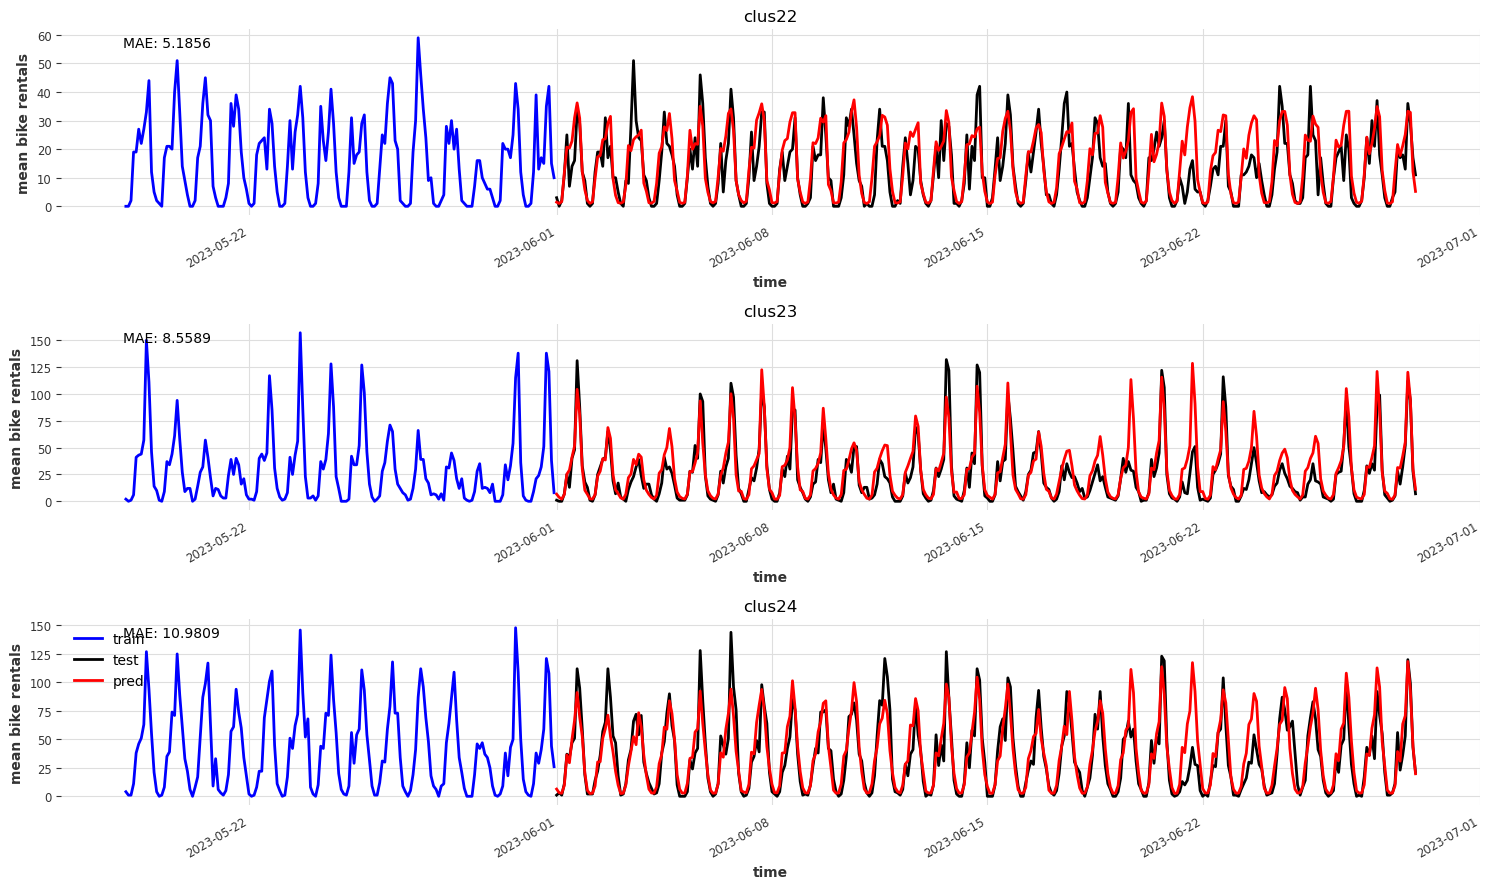

In [36]:
clus = [22, 23, 24]

fig, axs = plt.subplots(len(clus), 1, figsize=(15, 9))

for i, c in enumerate(clus):
    clus_label = f'clus{c}'

    train_ts[clus_label][-24*7:].plot(color="b", label="train", ax=axs[i])
    test_ts[clus_label][:24*14].plot(color="k", label="test", ax=axs[i])
    predictions[clus_label][:24*14].plot(color="r", label='pred', ax=axs[i])
    axs[i].set_ylabel('mean bike rentals')
    mae_text = f'MAE: {np.round(mae(predictions[clus_label],test_ts[clus_label]), 4)}'
    xlims = axs[i].get_xlim()
    ylims = axs[i].get_ylim()
    axs[i].annotate(mae_text, xy=(xlims[0]+2, ylims[1]*0.9))
    axs[i].set_title(clus_label)
fig.tight_layout()
plt.savefig(f"figs/clus_test_pred_LGB.png", format='png', transparent=True, bbox_inches='tight')
plt.show()

### Neural network model (test)

RNNs are a good alternative candidate for time series forecasting, particularly LSTMs which can capture seasonal patterns. Model architecture can take some time to fine-tune, so this is still WIP.

Would probably benefit from training on GPU for parallel computations.

In [37]:
# reset the train and val to original
train_ts = TimeSeries.from_dataframe(train_data.loc[:end_train, :])
val_ts = TimeSeries.from_series(train_data.loc[end_train:end_val, :])
test_ts = TimeSeries.from_series(test_data)

exog_all_ts = TimeSeries.from_dataframe(exog_all)
exog_train_ts = TimeSeries.from_dataframe(exog_train.loc[:end_train, :])
exog_val_ts = TimeSeries.from_dataframe(exog_train.loc[end_train:end_val, :])
exog_test_ts = TimeSeries.from_dataframe(exog_test)

encoders = {
    'cyclic': {'future': ['month', 'hour']},
    'datetime_attribute': {'future': ['year']},
}

In [38]:
# NNs require 0-1 scaled values, so use Scaler() here!
train_ts_scaled = Scaler().fit_transform(train_ts)
val_ts_scaled = Scaler().fit_transform(val_ts)

lstm_model = RNNModel(
    model="LSTM",
    input_chunk_length=24*5,
    output_chunk_length=24,
    training_length=24*5*5,
    hidden_dim=10,
    n_rnn_layers=1,
    batch_size=32,
    n_epochs=100,
    dropout=0.1,
    nr_epochs_val_period=1,
    optimizer_kwargs={"lr": 1e-3},
    model_name="rides_clus_RNN",
    log_tensorboard=True,
    random_state=42,
    force_reset=True,
    save_checkpoints=True,
)
lstm_model.fit(
    train_ts_scaled,
    future_covariates=exog_ts,
    val_series=val_ts_scaled,
    val_future_covariates=exog_val_ts,
    verbose=True,
)

ignoring user defined `output_chunk_length`. RNNModel uses a fixed `output_chunk_length=1`.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | rnn           | LSTM             | 2.0 K 
4 | V             | Linear           | 330   
---------------------------------------------------
2.3 K     Trainable params
0         Non-trainable params
2.3 K     Total params
0.009     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

RNNModel(model=LSTM, hidden_dim=10, n_rnn_layers=1, dropout=0.1, training_length=600, input_chunk_length=120, output_chunk_length=24, batch_size=32, n_epochs=100, nr_epochs_val_period=1, optimizer_kwargs={'lr': 0.001}, model_name=rides_clus_RNN, log_tensorboard=True, random_state=42, force_reset=True, save_checkpoints=True)

In [ ]:
def eval_model(model):
    pred_series = model.predict(n=26, future_covariates=exog_all)
    fig, axs = plt.subplots(3, 1, figsize=(12, 5))
    for i, ax in enumerate(axs):
        val_ts_scaled[f'clus{i}'][:24*14].plot(label="actual", linewidth=1.5, ax=ax)
        pred_series[f'clus{i}'][:24*14].plot(label="forecast", linewidth=1.5, ax=ax)
    plt.title("MAE: {:.2f}%".format(mae(pred_series, val_ts_scaled)))

eval_model(lstm_model)